<a href="https://colab.research.google.com/github/pradyutsingh/Neural-network/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


--2020-06-21 17:21:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  78.3MB/s    in 1.1s    

2020-06-21 17:21:43 (78.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
pre_trained_model = InceptionV3(
    include_top= False,
    input_shape = (150,150,3),
    weights=None
)
# now loading the weights
pre_trained_model.load_weights(local_weights_file)

#now making all the other layers untrainable
for layer in pre_trained_model.layers:
  layer.trainable = False

#model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print('the shape of the last layer is',last_layer.output_shape)
last_output = last_layer.output

the shape of the last layer is (None, 7, 7, 768)


In [4]:
from tensorflow.keras.optimizers import RMSprop
#flaten the output layer to one dimension
#last output is the output of the last considered layer in this case it is mized7
x = layers.Flatten()(last_output)
#add a fully connnected layer
x = layers.Dense(1024,activation = 'relu')(x)
#add a dropout layer
x = layers.Dropout(0.2)(x)
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)



In [5]:
model.compile(
    optimizer = RMSprop(lr=0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [6]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-06-21 17:21:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   147MB/s    in 0.4s    

2020-06-21 17:21:59 (147 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 
import zipfile
localzip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(localzip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#defining all the directories
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)




In [8]:
train_gen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
test_gen = ImageDataGenerator(rescale = 1.0/255)


In [9]:
train_generator = train_gen.flow_from_directory(
    train_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size=(150,150)
)
validation_generator = test_gen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    class_mode = 'binary',
    target_size=(150,150)
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_steps = 50,
    verbose = 2
)

Epoch 1/20
100/100 - 24s - loss: 0.3432 - accuracy: 0.8665 - val_loss: 0.1413 - val_accuracy: 0.9450
Epoch 2/20
100/100 - 22s - loss: 0.2190 - accuracy: 0.9185 - val_loss: 0.1136 - val_accuracy: 0.9620
Epoch 3/20
100/100 - 23s - loss: 0.2148 - accuracy: 0.9195 - val_loss: 0.1119 - val_accuracy: 0.9620
Epoch 4/20
100/100 - 22s - loss: 0.1831 - accuracy: 0.9325 - val_loss: 0.0965 - val_accuracy: 0.9690
Epoch 5/20
100/100 - 23s - loss: 0.1852 - accuracy: 0.9360 - val_loss: 0.1240 - val_accuracy: 0.9610
Epoch 6/20
100/100 - 22s - loss: 0.1847 - accuracy: 0.9335 - val_loss: 0.1179 - val_accuracy: 0.9610
Epoch 7/20
100/100 - 23s - loss: 0.1827 - accuracy: 0.9380 - val_loss: 0.0964 - val_accuracy: 0.9700
Epoch 8/20
100/100 - 22s - loss: 0.1747 - accuracy: 0.9355 - val_loss: 0.1123 - val_accuracy: 0.9660
Epoch 9/20
100/100 - 22s - loss: 0.1685 - accuracy: 0.9425 - val_loss: 0.1093 - val_accuracy: 0.9650
Epoch 10/20
100/100 - 22s - loss: 0.1748 - accuracy: 0.9305 - val_loss: 0.1509 - val_accura

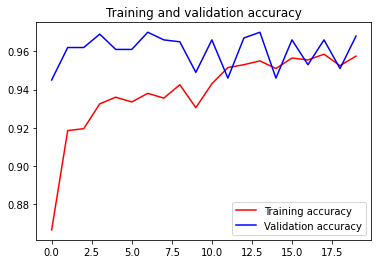

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()